In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [112]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [114]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


as we see all columns seems to be good but we have alot of zeros so we can replace them by the median value 

In [115]:
columns = df.columns
columns.drop('Outcome')
for col in columns:
    df[col] = df[col].replace(0, df[col].median())

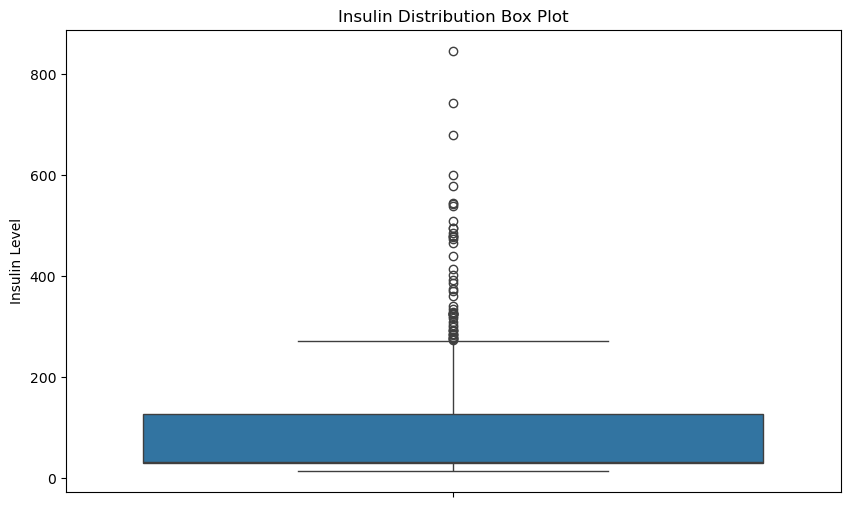

In [116]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Insulin'])
plt.title('Insulin Distribution Box Plot')
plt.ylabel('Insulin Level')
plt.show()

as we see there is outliers in insulin column which we can cap

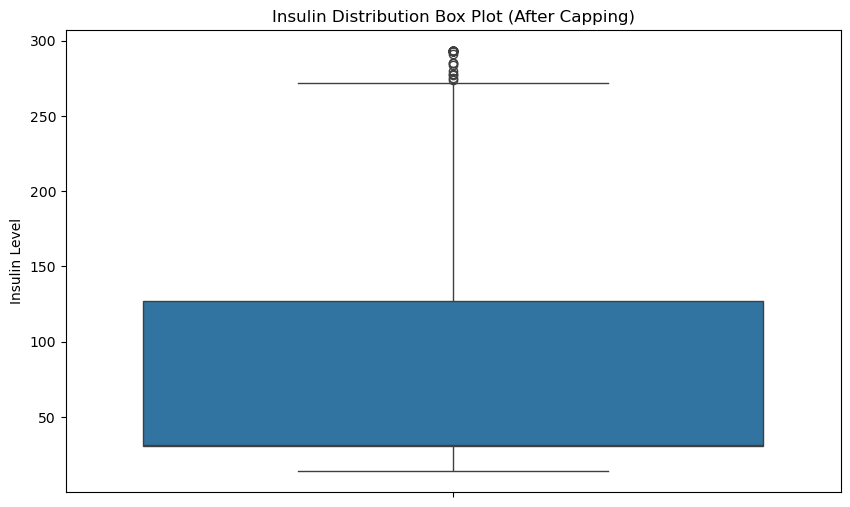

In [117]:
insulin_95th = df['Insulin'].quantile(0.95)
df['Insulin'] = df['Insulin'].clip(upper=insulin_95th)

plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Insulin'])
plt.title('Insulin Distribution Box Plot (After Capping)')
plt.ylabel('Insulin Level')
plt.show()

Outcome
0    500
1    268
Name: count, dtype: int64


<AxesSubplot: xlabel='Outcome'>

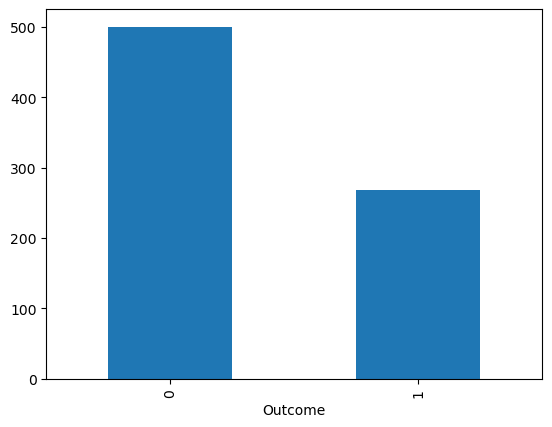

In [118]:
print(df['Outcome'].value_counts())
df['Outcome'].value_counts().plot(kind='bar')

let's see the correlation matrix for all columns and the outcome what will affect it more

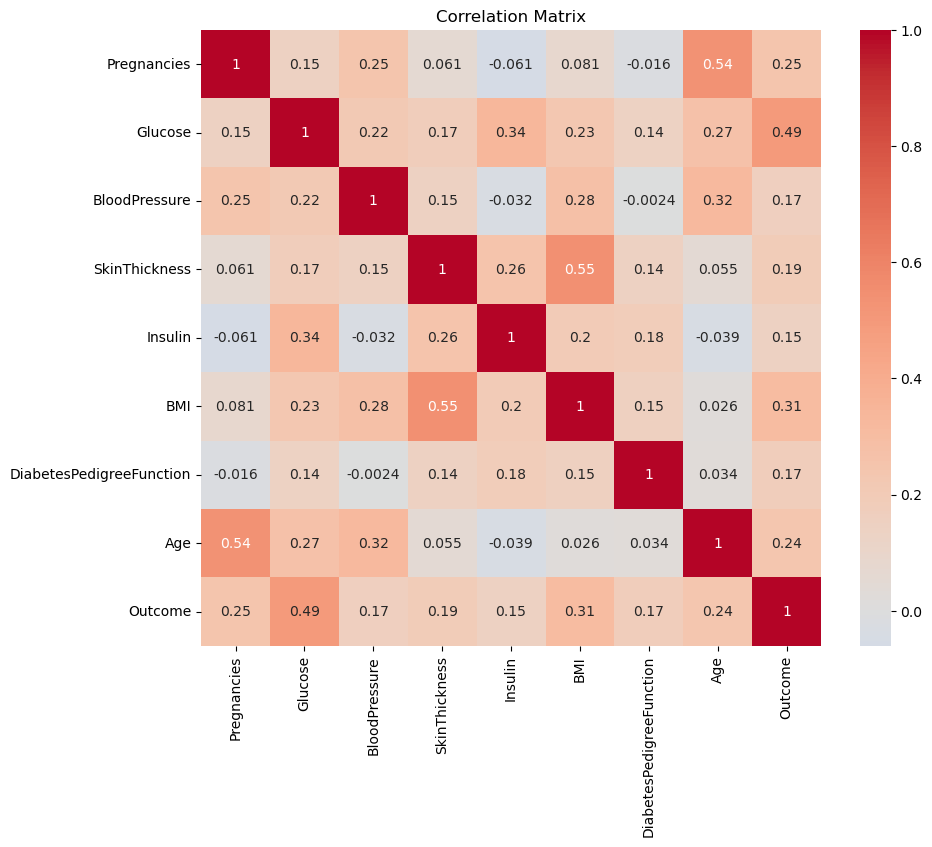

In [119]:
# Create correlation matrix
corr_matrix = df.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

Glucose vs. Outcome → Correlation is 0.47, which is moderately strong and positive.
This means higher glucose levels are fairly strongly associated with a higher likelihood of a positive outcome (likely diabetes in this dataset).

BMI vs. Outcome → Correlation is 0.29, which is weaker than glucose but still positive.
This suggests BMI does play a role, but not as strongly as glucose. It has some predictive value but is not the dominant factor.

In [120]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic regression

In [121]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(x_train, y_train)
y_pred_logistic = logistic_model.predict(x_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



## svm


In [122]:
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf'))
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

,estimator,"Pipeline(step...svc', SVC())])"
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}


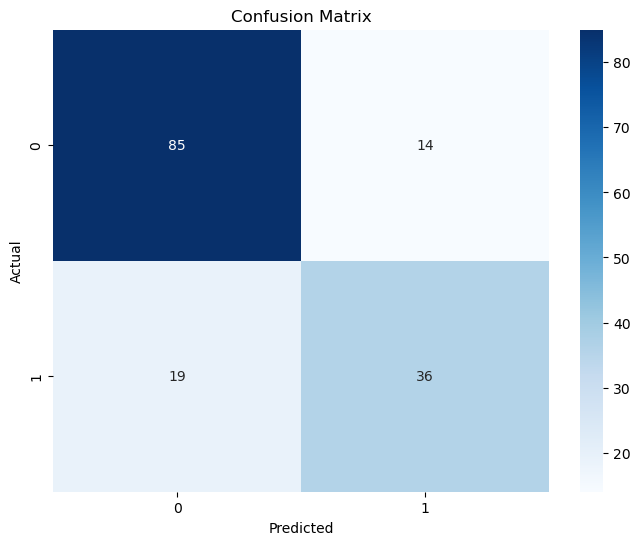

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        99
           1       0.72      0.65      0.69        55

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.76       154
weighted avg       0.78      0.79      0.78       154



In [123]:
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)
y_pred = grid_search.predict(x_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

- as we see the SVM gave us higher accuracy compared to logistic regression
- with Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}

## let's now add a data to predict it

we start by reading the data itself

In [126]:
from tkinter import filedialog
import tkinter as tk

# Create and hide the tkinter root window
root = tk.Tk()
root.withdraw()

# Open file dialog for CSV selection
file_path = filedialog.askopenfilename(
    title="Select CSV file",
    filetypes=[("CSV files", "*.csv")]
)

if file_path:
    new_df = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    print("\nFirst few rows of the data:")
    print(new_df.head())
else:
    print("No file selected")

CSV file loaded successfully!

First few rows of the data:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


then we will make the predection using the svm

In [127]:
new_df = new_df[X.columns]
new_pred = grid_search.predict(new_df)
print("Prediction for the new data:")
print(new_pred)

Prediction for the new data:
[1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1
 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 